In [1]:
import pickle
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
PSD_dir = "../../../../data/test_correlation/data_mahy"
output_path = "/home/imonge/Documents/Masking"
hydrophone_number = 1 # choose between 1, 2, 3, 4

In [3]:
# select the stations you want to plot. /!\ You can only choose stations for one hydrophone

if hydrophone_number != 4:
    selected_stations = [f"MAHY0{hydrophone_number}",
                         f"MAHY1{hydrophone_number}",
                         f"MAHY2{hydrophone_number}",
                         f"MAHY3{hydrophone_number}",
                         f"MAHY4{hydrophone_number}",
                         ]
else:
    selected_stations = [f"MAHY0{hydrophone_number}",
                         f"MAHY1{hydrophone_number}",
                         f"MAHY3{hydrophone_number}",
                         f"MAHY4{hydrophone_number}",
                         ]

In [4]:
# Load the PSD data
psds_all = []
for station in selected_stations:
    psd_path = os.path.join(PSD_dir, f"{station}.pkl")
    psds_all.append(pd.read_pickle(psd_path))

# Concatenate psds
psd_df = pd.concat(psds_all).sort_index()

# Change 0 to NaN
psd_df.replace(0, np.nan, inplace=True)

# Change absent data to Nan
full_index = pd.date_range(start=psd_df.index.min(), end=psd_df.index.max(), freq="h")
psd_reindexed = psd_df.reindex(full_index)

In [12]:
## Spectral probability density
psd_db = 10 * np.log10(psd_reindexed)
# Parameters
frequencies = psd_db.columns.values.astype(float)
psd_values = psd_db.values

# Define psds bins in dB
vmin = np.nanpercentile(psd_db, 1)
vmax = np.nanpercentile(psd_db, 99)
bins = np.linspace(vmin, vmax, 100)

# Calculate density for each frequency
pdf_matrix = []

for i in range(len(frequencies)):
    psd_col = psd_values[:, i]
    # psd_col = psd_col[~np.isnan(psd_col)]
    freq = frequencies[i]
    if freq < 1:
        continue

    # Normalised histogram
    hist, _ = np.histogram(psd_col, bins = bins, density = True)
    pdf_matrix.append(hist)

pdf_matrix = np.array(pdf_matrix).T
pdf_masked = np.ma.masked_where(pdf_matrix <= 0.001, pdf_matrix)

# Percentiles and arithmetic mean
percentiles =  np.nanpercentile(psd_values,[5, 50, 95], axis=0)
mean_db = np.nanmean(psd_values, axis=0)

# Dictionary for species information (short name, most energetic frequency, line color, position in the legend)
species_info = {
    "Omura's whale (20-30 Hz)": {"short": "Omura 20", "freq":19, "color": "#d45b99", "ha":"right"},
    "Fin whale": {"short": "FW", "freq": 21.5, "color":"#8c564b", "ha": "center"},
    "Antarctic blue whale": {"short": "ABW", "freq": 25, "color": "#ff7f0e", "ha": "center"},
    "Madagascan pygmy blue whale": {"short": "PBW-SWIO", "freq": 33, "color": "#1f77b4", "ha": "center"},
    "Omura's whale (30-40 Hz)": {"short": "Omura 30", "freq": 35, "color":"#9467bd", "ha":"left"},
    "Sri Lanka pygmy blue whale": {"short": "PBW-CIO", "freq": 95, "color": "#2ca02c", "ha": "center"}
}

# Plot
fig, ax = plt.subplots(figsize=(15, 8))
extent = [1, frequencies.max(), bins[0], bins[-1]]
img = ax.imshow(pdf_masked, origin='lower', aspect='auto', extent=extent, cmap='plasma', vmax=0.1)

# Add horizontal lines  for each species
species_legend = []

# Place species ticks in zigzag
text_y_base = bins[-1] + 1
zigzag_offsets = [0, 2.5, 0, 2.5, 0, 0]

for idx, (species,info) in enumerate(species_info.items()):
    freq = info["freq"]
    short = info["short"]
    color = info["color"]
    ha = info.get("ha", "center") # center is default value

    # Vertical line
    ax.axvline(freq, color=color, linewidth=1.7, alpha=0.8)

    # Species label positioning
    if ha == "left":
        x_pos = freq - 1.5
    elif ha == "right":
        x_pos = freq + 1.5
    else:
        x_pos = freq

    # Zigzag text
    offset = zigzag_offsets[idx % len(zigzag_offsets)]
    ax.text(freq, text_y_base + offset, short, rotation=0, va='bottom', ha=ha, fontsize=16, color=color, fontweight='bold')
    # Legend text
    species_legend.append(Line2D([0], [0], color=color, lw=2, label=f'{short}: {species}'))

# Ticks and labels
ax.set_xlabel("f (Hz)", fontsize=18)
ax.set_ylabel("PSD (dB re 1 µPa²/Hz)", fontsize=18)

ax.set_xlim(2,118)
ax.set_ylim(bins[0], bins[-1])

xticks = ax.get_xticks()
xticks = np.append(xticks, [2, 118])
xticks = xticks[(xticks >= 2) & (xticks <= 118)]

ax.set_xticks([2, 20, 40, 60, 80, 100, 118])
ax.set_xticks(np.unique(xticks))

ax.tick_params(axis="x", direction="out", which="both", length=6, width=1.5, top=False, bottom=True, labelsize=16)
ax.tick_params(axis="y", direction="out", which="both", length=6, width=1.5, right=False, left=True, labelsize=16)

plt.suptitle(f"Spectral Probability Density (SPD) - hydrophone {hydrophone_number}", fontsize=18, y=0.98)

# Colorbar
cbar = fig.colorbar(img, ax=ax, pad=0.02)
cbar.set_label("Probability Density", fontsize=18, labelpad=10)
cbar.ax.tick_params(labelsize=16)

# Mean and percentiles curves
ax.plot(frequencies, mean_db, color='red', linewidth=1.5, label = 'Arithmetic mean (AM)', zorder=3)

labels = ['5%', '50%', '95%']
gray_levels = [0.9, 0.6, 0]
for i, (p, label, gray) in enumerate(zip(percentiles, labels, gray_levels)):
    ax.plot(frequencies, p, color=str(gray), linewidth=1.5)

    # Put percentile index in the middle
    mid_idx = len(frequencies) //2
    freq_mid = frequencies[mid_idx]
    psd_mid = p[mid_idx]

    # Add label under the curve
    ax.text(freq_mid, psd_mid - 1.5, label, color=str(gray), fontsize=16, ha='center', va='top', fontweight='bold')

mean_line = Line2D([0], [0], color='red', lw=1.5, label='AM')
percentile_lines = [
    Line2D([0], [0], color=str(gray), lw=1.5, label=label)
    for label, gray in zip(labels, gray_levels)
]
legend1_lines = [mean_line] + percentile_lines


# Legend 1 - Percentiles and mean
legend1 = ax.legend(handles=[mean_line], loc='lower left', fontsize=14)
ax.add_artist(legend1)

# Legend 2 : species
legend2 = ax.legend(handles=species_legend, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=3, fontsize=16, frameon=False)
ax.add_artist(legend2)
ax.grid(False)

plt.tight_layout(rect=[0, 0.15, 1, 1])


# # Save figure
# output_path = "/home/imonge/Documents/Masking"
# plt.savefig(os.path.join(output_path, f'SPD_h{hydrophone_number}.png'), bbox_inches='tight')

plt.show()
%matplotlib qt

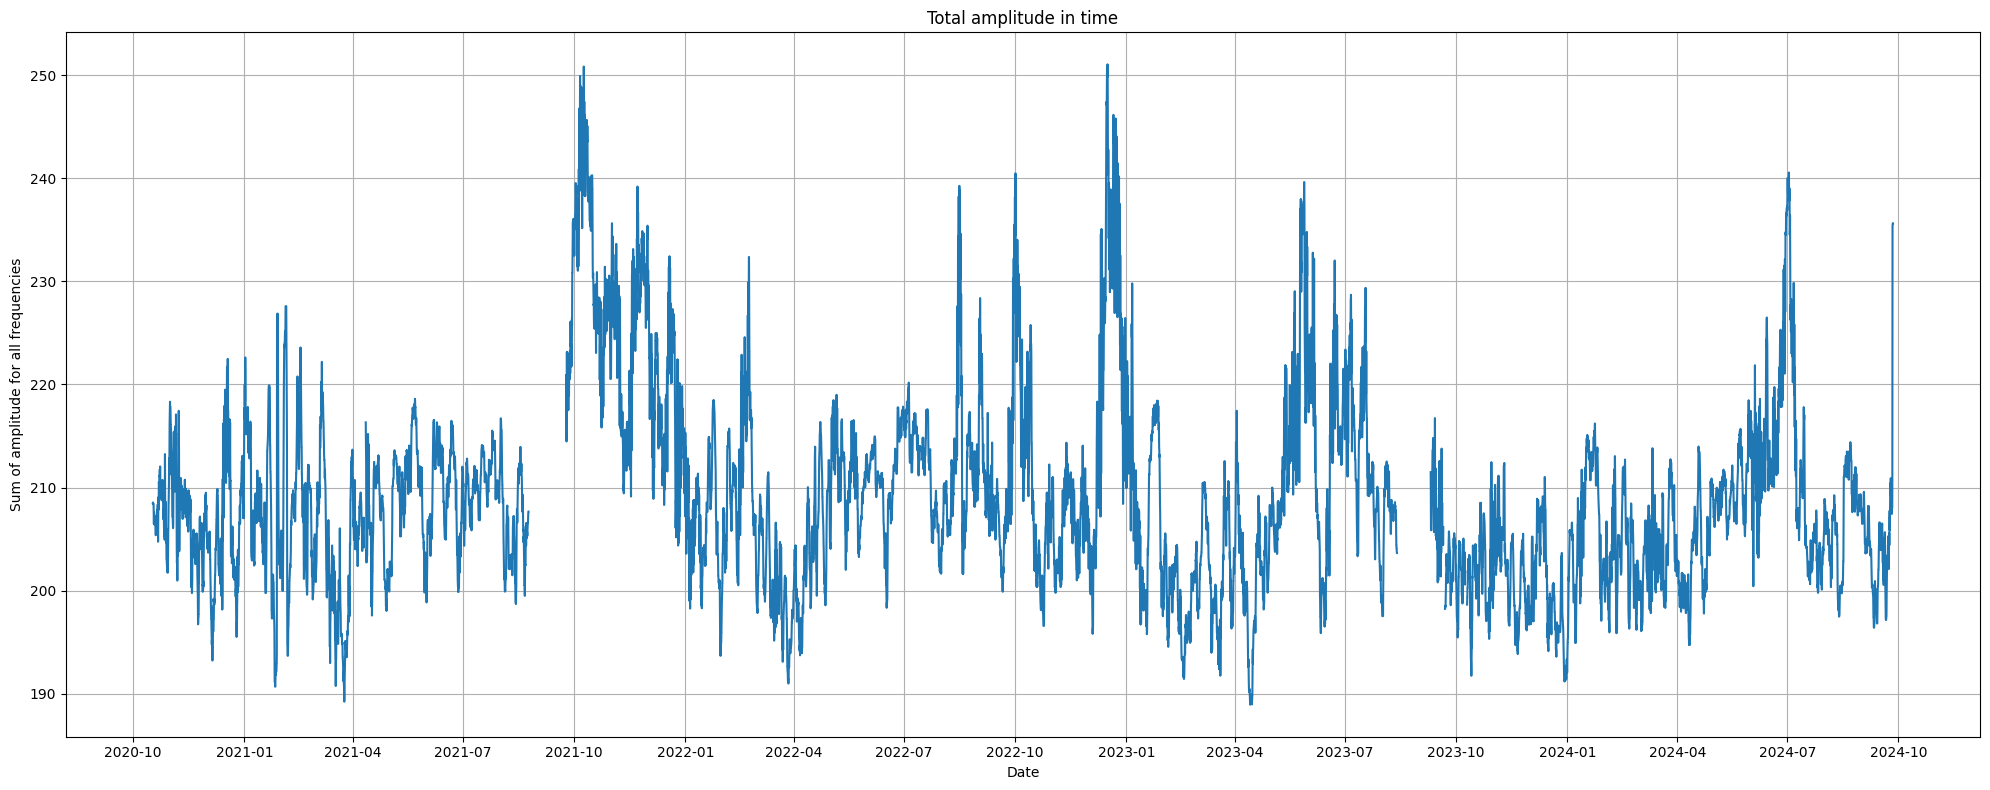

In [8]:
## Plot total amplitude in time (for all frequencies)
psd_total = psd_reindexed.mean(axis=1)
psd_total = np.log(psd_total) * 10

# Median filter
psd_filt = psd_total.rolling(window=30).median()

# Plot
plt.figure(figsize=(20,8))
plt.plot(psd_total.index, psd_filt.values, label="Total amplitude of the psd")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# plt.gca().xaxis.set_major_locator(mdates.DateFormatter('%Y-%m'))

plt.title("Total amplitude in time")
plt.xlabel("Date")
plt.ylabel("Sum of amplitude for all frequencies")
plt.grid(True)
plt.tight_layout()
plt.show()

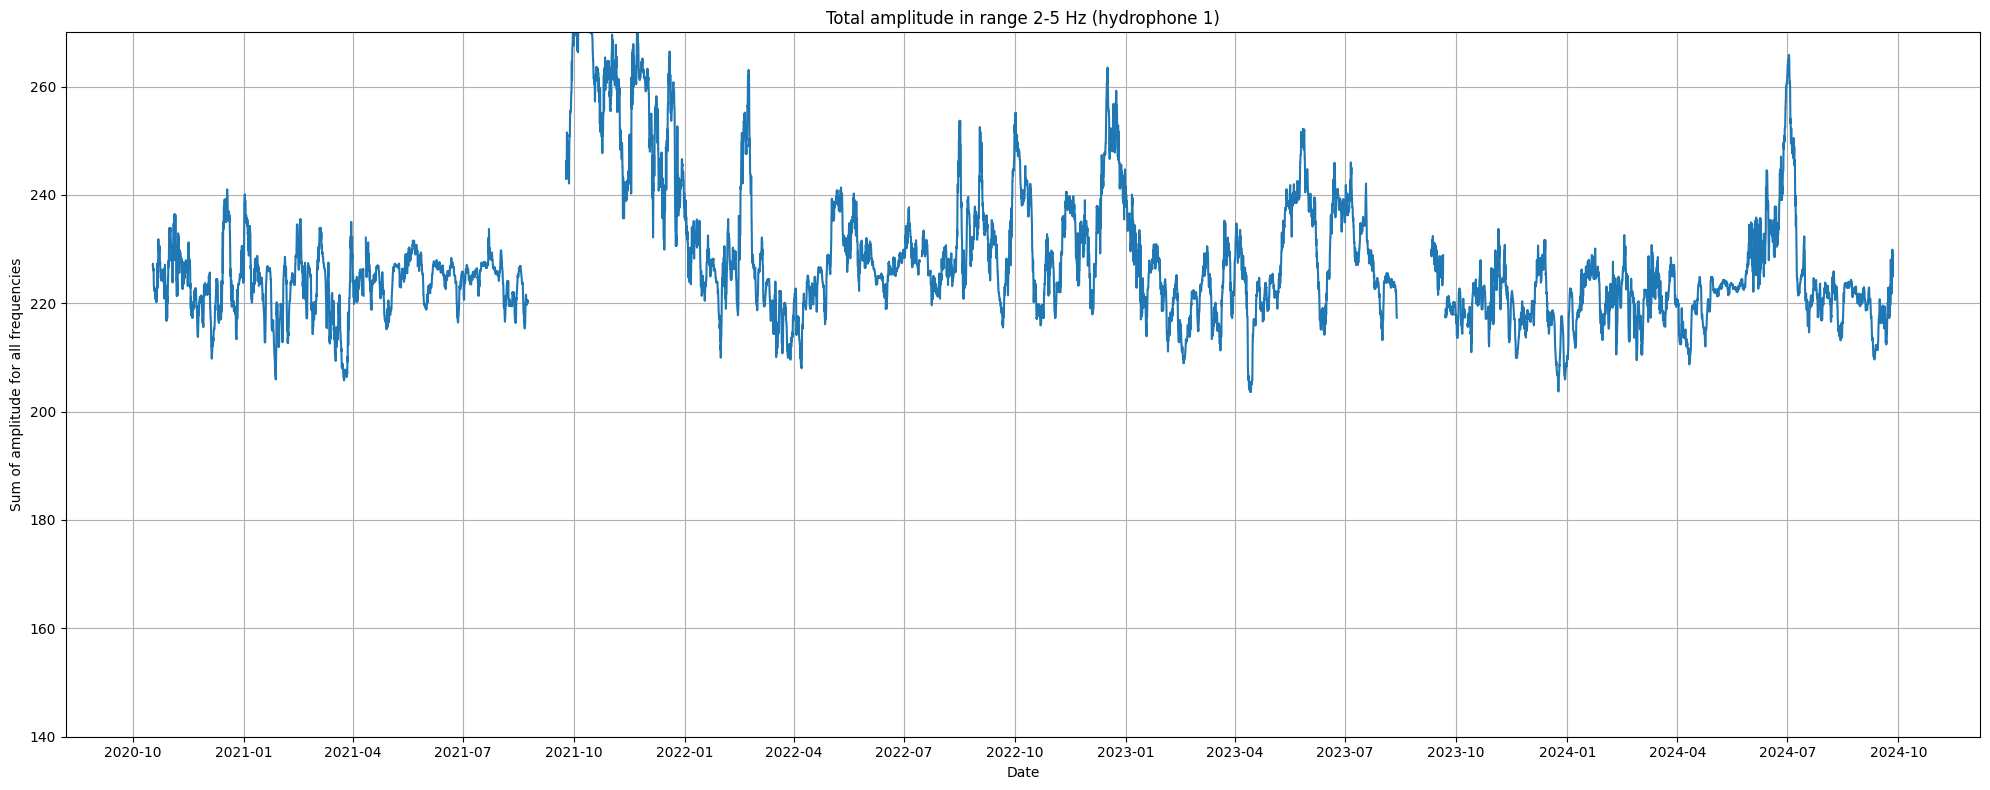

In [6]:
## Plot total amplitude in time for specified ranges
fmin = 2
fmax = 5
freq_range = (fmin, fmax)
frequencies = [f for f in psd_df.columns if freq_range[0] <= f <= freq_range[1]]

psd_band = psd_reindexed[frequencies]
psd_total = psd_band.mean(axis=1)
psd_total = np.log(psd_total) * 10

# Median filter
psd_filt = psd_total.rolling(window=40).median()

# Plot
plt.figure(figsize=(20,8))
plt.plot(psd_total.index, psd_filt.values, label="Total amplitude of the psd")

# # Darkened blocks
# for start, end in nan_blocks:
#     plt.axvspan(start, end, alpha=0.2)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# plt.gca().xaxis.set_major_locator(mdates.DateFormatter('%Y-%m'))

plt.title(f"Total amplitude in range {fmin}-{fmax} Hz (hydrophone {hydrophone_number})")
plt.xlabel("Date")
plt.ylabel("Sum of amplitude for all frequencies")
plt.ylim(140, 270)
plt.grid(True)
plt.tight_layout()
plt.show()